Preprocessing 

In [1]:
# Import the required libraries and dependencies
import pandas as pd
import hvplot.pandas
import os
import tensorflow as tf
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#  Import and read the Ghibli_characters.csv
df = pd.read_csv("..\\project4\Resources\StudioGhibliCharacters - Sheet1.csv")
df.head()

,character name,age,height(cm),eyeColor,hairColor,specialPowers,country/placeOfResidence,gender,species,movie,releaseDate
0,Pazu,13.0,120.0,black,brown,0,Laputa,Male,Human,Castle in the Sky,1986
1,Lusheeta Toel Ul Laputa,13.0,120.0,black,black,1,Laputa,Female,Human,Castle in the Sky,1986
2,Dola,60.0,NaN,black,peach,0,Laputa,Female,Human,Castle in the Sky,1986
3,Romka Palo Ul Laputa,33.0,NaN,black,brown,0,Laputa,Male,Human,Castle in the Sky,1986
4,Uncle Pom,NaN,NaN,black,white,0,Laputa,Male,Human,Castle in the Sky,1986


In [16]:
# Create Path for sqlite databse
Path('ghib_data.db').touch()

# Connect to SQLite database 
conn = sqlite3.connect('ghib_data.db') 
  
# Load CSV data into Pandas DataFrame 
ghib = pd.read_csv('..\\project4\Resources\StudioGhibliCharacters - Sheet1.csv') 
# Write the data to a sqlite table 
ghib.to_sql('sg_char', conn, if_exists='replace', index=False) 
  
# Create a cursor object 
cur = conn.cursor() 
# Fetch and display result 
for row in cur.execute('SELECT * FROM sg_char'): 
    print(row) 

('Pazu', 13.0, 120.0, 'black', 'brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Lusheeta Toel Ul Laputa', 13.0, 120.0, 'black', 'black', 1, 'Laputa', 'Female', 'Human', 'Castle in the Sky', 1986)
('Dola', 60.0, None, 'black', 'peach', 0, 'Laputa', 'Female', 'Human', 'Castle in the Sky', 1986)
('Romka Palo Ul Laputa', 33.0, None, 'black', 'brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Uncle Pom', None, None, 'black', 'white', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('General Muoro', None, None, 'black', 'bald', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Duffi', None, None, 'dark brown', 'dark brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Louis', 30.0, None, 'dark brown', 'dark brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Charles ', None, None, 'dark brown', 'light brown', 0, 'Laputa', 'Male', 'Human', 'Castle in the Sky', 1986)
('Henri', None, None, 'dark brown', 'reddish 

In [4]:
# Query database for all distinct species and their counts to evaluate how to catergorize predictions
species_query = """
SELECT DISTINCT species, COUNT(species)
FROM sg_char
GROUP BY species;
"""

all_species = pd.read_sql_query(species_query, conn)
all_species

,species,COUNT(species)
0,Arch-Mage,1
1,Bakeneko,1
2,Boar God,1
3,Borrower,5
4,Cat,7
5,Deity,1
6,Dog,1
7,Dragon/Human,1
8,Fire Demon,1
9,Fish/Human,1


In [5]:
# Query database for Males vs Females
male_query = """
SELECT gender, COUNT(gender)
FROM sg_char
GROUP BY gender;
"""

male_characters = pd.read_sql_query(male_query,conn)
male_characters

,gender,COUNT(gender)
0,None,0
1,Female,84
2,Male,98


In [6]:
# Query database for all characters that share same eye color
eyeColor_query = """
SELECT eyeColor, COUNT(eyeColor)
FROM sg_char
GROUP BY eyeColor;
"""

same_eyeColors = pd.read_sql_query(eyeColor_query,conn)
same_eyeColors

,eyeColor,COUNT(eyeColor)
0,None,0
1,black,78
2,black,2
3,blue,5
4,brown,36
5,brown,1
6,dark brown,32
7,emerald,1
8,green,4
9,green grey,1


In [7]:
# Query database for all characters that share hair color
hairColor_query = """
SELECT hairColor, COUNT(hairColor)
FROM sg_char
GROUP BY hairColor;
"""

same_hairColors = pd.read_sql_query(hairColor_query,conn)
same_hairColors

,hairColor,COUNT(hairColor)
0,None,0
1,auburn,3
2,bald,6
3,beige,2
4,beige white,1
5,black,21
6,blonde,6
7,blue,1
8,brown,65
9,brown striped,1


In [8]:
# Query how many characters are in a movie
charInMovie = """
SELECT movie, COUNT('character name') as numberOfCharacters
FROM sg_char
GROUP BY movie;
"""

movies = pd.read_sql_query(charInMovie,conn)
movies

,movie,numberOfCharacters
0,Castle in the Sky,13
1,From Up on Poppy Hill,8
2,Grave of the Fireflies,6
3,Howl's Moving Castle,9
4,Kiki's Delivery Service,6
5,My Neighbor Totoro,10
6,My Neighbors the Yamadas,5
7,Nausicaa of the Valley of the Wind,13
8,Only Yesterday,10
9,Pom Poko,6


In [38]:
# Close connection to SQLite database 
conn.close() 

In [39]:
# clean dataframe and drop non-beneficial 
cleanedCharacters = df.drop(columns = ['character name','movie', 'releaseDate', 'country/placeOfResidence', 'gender'], axis=1)
cleanedCharacters.head(20)

,age,height(cm),eyeColor,hairColor,specialPowers,species
0,13.0,120.0,black,brown,0,Human
1,13.0,120.0,black,black,1,Human
2,60.0,NaN,black,peach,0,Human
3,33.0,NaN,black,brown,0,Human
4,NaN,NaN,black,white,0,Human
5,NaN,NaN,black,bald,0,Human
6,NaN,NaN,dark brown,dark brown,0,Human
7,30.0,NaN,dark brown,dark brown,0,Human
8,NaN,NaN,dark brown,light brown,0,Human
9,NaN,NaN,dark brown,reddish brown,0,Human


In [48]:
# Find median height(cm)
medHeights = cleanedCharacters['height(cm)'].median()
medHeights

140.0

In [51]:
# Find median age
medAge = cleanedCharacters['age'].median()
medAge

18.0

In [57]:
# Replace all age NaN values with median age to keep character
characters_age = cleanedCharacters['age'].replace(np.nan, 18)
characters_age.head()

0    13.0
1    13.0
2    60.0
3    33.0
4    18.0
Name: age, dtype: float64

In [58]:
# Replace all height NaN values with median height to keep character
character_height = cleanedCharacters['height(cm)'].replace(np.nan, 140)
character_height.head()

0    120.0
1    120.0
2    140.0
3    140.0
4    140.0
Name: height(cm), dtype: float64

In [63]:
# Replace original age and height columns with new columns
characters_df = cleanedCharacters.copy()
characters_df.drop(columns=['age','height(cm)'], axis=1, inplace=True)
characters_df['age'] = characters_age
characters_df['height(cm)'] = character_height
characters_df.head()

,eyeColor,hairColor,specialPowers,species,age,height(cm)
0,black,brown,0,Human,13.0,120.0
1,black,black,1,Human,13.0,120.0
2,black,peach,0,Human,60.0,140.0
3,black,brown,0,Human,33.0,140.0
4,black,white,0,Human,18.0,140.0


In [64]:
# Scale price data, return, and variance values
data_scaled = StandardScaler().fit_transform(
    characters_df[["age","height(cm)"]]
)

In [65]:
# Create a DataFrame with the scaled data
df_data_scaled = pd.DataFrame(
    data_scaled,
    columns=[["age","height(cm)"]]
)

# Display sample data
df_data_scaled.head()

,age,height(cm)
0,-0.255214,-0.549333
1,-0.255214,-0.549333
2,0.121358,0.151376
3,-0.094970,0.151376
4,-0.215153,0.151376


In [66]:
# get_dummies to convert categorical values to numerical values
cat_dum = cleanedCharacters.copy()
cat_dum.drop(columns=["age","species","height(cm)"], axis=1, inplace=True)
cat_dum2 = pd.concat([cat_dum, df_data_scaled], axis=1)
ghibli_dummies = pd.get_dummies(cat_dum2)
ghibli_dummies.head()

,specialPowers,"(age,)","(height(cm),)",eyeColor_black,eyeColor_black,eyeColor_blue,eyeColor_brown,eyeColor_brown,eyeColor_dark brown,eyeColor_emerald,...,hairColor_orange yellow,hairColor_peach,hairColor_purple,hairColor_red,hairColor_red,hairColor_reddish brown,hairColor_russian blue,hairColor_white,hairColor_whtie,hairColor_yellow
0,0,-0.255214,-0.549333,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,-0.255214,-0.549333,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,0.121358,0.151376,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0,-0.094970,0.151376,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,-0.215153,0.151376,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [67]:
print(ghibli_dummies)

     specialPowers    (age,)  (height(cm),)  eyeColor_black  eyeColor_black   \
0                0 -0.255214      -0.549333            True            False   
1                1 -0.255214      -0.549333            True            False   
2                0  0.121358       0.151376            True            False   
3                0 -0.094970       0.151376            True            False   
4                0 -0.215153       0.151376            True            False   
..             ...       ...            ...             ...              ...   
179              0 -0.231177       0.151376           False            False   
180              0 -0.231177       0.151376           False            False   
181              0 -0.215153       0.151376           False            False   
182              0 -0.159068       0.151376           False            False   
183              0 -0.215153       0.151376           False            False   

     eyeColor_blue  eyeColor_brown  eye

In [68]:
# Look at Species types for catergorizing
species_class = df['species']
species_class.head()

0    Human
1    Human
2    Human
3    Human
4    Human
Name: species, dtype: object

In [69]:
# Create All Human species classifications to be replaced with 0
Humans = species_class[(species_class == "Human") | (species_class == "New Human")]

# Replace in dataframe
for species in Humans:
    df['species'] = df['species'].replace(species,"0")

# Check to make sure binning was successful
df['species']

0      0
1      0
2      0
3      0
4      0
      ..
179    0
180    0
181    0
182    0
183    0
Name: species, Length: 184, dtype: object

In [70]:
# Create All other species classifications to be replaced with 1
OtherSpecies = species_class[species_class != "Human"]

# Replace in dataframe
for species in OtherSpecies:
    df['species'] = df['species'].replace(species,"1")

# Check to make sure binning was successful
df['species'].head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    1
Name: species, dtype: object

In [71]:
# split data into features and target arrays
y = df['species'].astype('float64')
X = ghibli_dummies.values

In [72]:
# show first 3 X values
X[:3]

array([[0, -0.2552137275197594, -0.549333357148503, True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [1, -0.2552137275197594, -0.549333357148503, True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False],
       [0, 0.12135824238143139, 0.15137608975149336, True, False, False,
        False, 

In [73]:
# show 20 y values
y[:20]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    1.0
Name: species, dtype: float64

In [74]:
# split data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
print("Training Data Info")
print("Training Data Shape:", X_train.shape)
print("Training Data Labels Shape:", y_train.shape)

Training Data Info
Training Data Shape: (138, 54)
Training Data Labels Shape: (138,)


Compile, Train and Evaluate the Model

In [75]:
# Create Standard Scaler
scaler = StandardScaler()

# Fit scaler to training data
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [76]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=5, activation='relu', input_dim=54))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=10, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=20, activation='tanh'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 275       
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                220       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 576 (2.25 KB)
Trainable params: 576 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [78]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=72)

Epoch 1/72
5/5 [==============================] - 2s 4ms/step - loss: 0.7096 - accuracy: 0.3043
Epoch 2/72
5/5 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.4565
Epoch 3/72
5/5 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.6449
Epoch 4/72
5/5 [==============================] - 0s 4ms/step - loss: 0.6500 - accuracy: 0.7681
Epoch 5/72
5/5 [==============================] - 0s 5ms/step - loss: 0.6344 - accuracy: 0.8188
Epoch 6/72
5/5 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.8261
Epoch 7/72
5/5 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.8551
Epoch 8/72
5/5 [==============================] - 0s 4ms/step - loss: 0.5913 - accuracy: 0.8623
Epoch 9/72
5/5 [==============================] - 0s 4ms/step - loss: 0.5774 - accuracy: 0.8623
Epoch 10/72
5/5 [==============================] - 0s 4ms/step - loss: 0.5642 - accuracy: 0.8551
Epoch 11/72
5/5 [======================

In [79]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 0.1874 - accuracy: 0.9130 - 194ms/epoch - 97ms/step
Loss: 0.18737050890922546, Accuracy: 0.9130434989929199


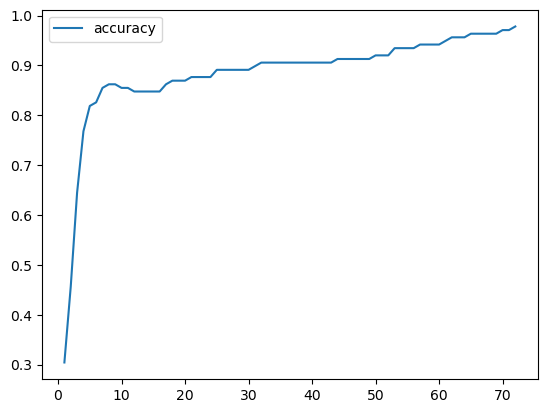

In [80]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [81]:
# Export our model to HDF5 file
nn.save('SG_Model.h5')

C:\Users\yangt\anaconda3\envs\dev\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
